# TIDE Evaluation
You will most often be only computing PR-curves and mAP values, but sometimes you just wish you could have a little bit more insight into the performance of your model.

Fear not, for your prayers have been heard!  
A lot of smart people spend time building tools to be able to analyze your detection results more closely.
One of these tools, [TIDE](https://github.com/dbolya/tide) has been reimplemented in brambox for your convenience.
The creators of TIDE have made a [nice video](https://www.youtube.com/watch?v=McYFYU3PXcU), where they explain everything, thus we won't bother reexplaining it all.

So how do we run this in brambox?  
Well, the answer is pretty easy, you just use [brambox.eval.TIDE](../api/generated/brambox.eval.TIDE.rst).


<div class="alert alert-info">

**Note:**  
While this tutorial discusses [TIDE](../api/generated/brambox.eval.TIDE.rst), brambox also provides a [TIDAL](../api/generated/brambox.eval.TIDAL.rst) tool.  
TIDAL is a custom variant of TIDE, but the API is mostly the same and this tutorial thus works for both.

</div>

In [1]:
from math import ceil

import seaborn as sns
from IPython.display import display
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MaxNLocator

import brambox as bb

# Settings
sns.set_theme(style='ticks', context='notebook')

Firstly, we need to load in the data.  
We use the same data as for the [COCO tutorial](./03-A-coco.ipynb), so we refer to that tutorial for an explanation about the data manipulations performed here.

In [2]:
anno = bb.io.load('anno_coco', 'instances_val2017.json')
anno.head()

image   class_label  x_top_left  y_top_left   width  height  ignore  \
0  000000000139  potted plant      236.98      142.51   24.70   69.50   False   
1  000000000139            tv        7.03      167.76  149.32   94.87   False   
2  000000000139            tv      557.21      209.19   81.35   78.73   False   
3  000000000139         chair      358.98      218.05   56.00  102.83   False   
4  000000000139         chair      290.69      218.00   61.83   98.48   False   

       id  
0   26547  
1   34646  
2   35802  
3  103487  
4  104368

In [3]:
det = bb.io.load(
    'det_coco',
    'FasterRCNNX-101-32x8d-FPN.json',
    # We need to map the numbers from the JSON file to actual classnames
    class_label_map=[lines.strip() for lines in open('coco.names')]
)

# The image labels are just numbers in the COCO json files, so we need to rename those as well
det.image = det.image.cat.rename_categories(lambda img: f'{img:012}')

# Finally, not all images might contain detections,
# and because the coco detection format does not contain a list of all images, we need to fix this ourselves
# Note that this is optional, but you will get a warning if you dont do this
det.image = det.image.cat.add_categories(set(anno.image.cat.categories) - set(det.image.cat.categories))

det.head()

image class_label  x_top_left  y_top_left      width      height  \
0  000000000139         cup  256.541962   19.896376  39.251343   33.478731   
1  000000000139       clock  448.346619  120.699646  13.140076   21.216888   
2  000000000139      bottle  496.147217  154.150909   6.602356   19.609589   
3  000000000139        vase  493.959656  155.384613   8.966003   17.967621   
4  000000000139      person  410.216278  155.865784  55.939636  140.064117   

   confidence  
0    0.052693  
1    0.943210  
2    0.070206  
3    0.074621  
4    0.992891

## Running TIDE
Once we loaded the data, we can run the TIDE evaluation!

In [4]:
tide = bb.eval.TIDE(det, anno)
tide.mdAP

Fixing Errors:   0%|          | 0/80 [00:00<?, ?it/s]

mAP                    0.636711
mdAP_localisation      0.071168
mdAP_classification    0.026013
mdAP_both              0.011561
mdAP_duplicate         0.002135
mdAP_background        0.040573
mdAP_missed            0.070524
mdAP_fp                0.167002
mdAP_fn                0.139611
dtype: float64

We can also look at the different $\Delta$AP values for each class.

In [5]:
tide.dAP_localisation

apple         0.073102
bed           0.108503
laptop        0.038053
umbrella      0.099237
sandwich      0.069558
                ...   
cake          0.071197
remote        0.122506
carrot        0.100267
banana        0.178310
toothbrush    0.085499
Length: 80, dtype: float64

One feature that is presented in the TIDE paper, but that is not yet available in the official package (V1.0.1), is generating results for bounding boxes of different sizes.

In Brambox however, this is already possible!  
Just add an `area_range` when creating your TIDE object, and it will only consider annotations and detections inside of this range.
This works similar to how COCO filters bounding boxes for their Small, Medium and Large categories.


<div class="alert alert-info">

**Note:**  
Since the official package has not yet released the code for doing this, we are not able to verify our results against theirs and thus provide this feature without guarantee of achieving the same results.

</div>

In [6]:
# The TIDE class has some predefined (coco) area ranges
tide_large = bb.eval.TIDE(det, anno, area_range=bb.eval.TIDE.coco_areas['large'])
tide_large.mdAP

Fixing Errors:   0%|          | 0/80 [00:00<?, ?it/s]

mAP                    0.770537
mdAP_localisation      0.065828
mdAP_classification    0.025586
mdAP_both              0.014340
mdAP_duplicate         0.002334
mdAP_background        0.025122
mdAP_missed            0.040998
mdAP_fp                0.135156
mdAP_fn                0.074558
dtype: float64

## Plotting TIDE results
TIDE allows you to generate compact plots that show the mean-$\Delta$AP values of your detector, providing a nice overview.  
However, we believe that plotting falls outside of the scope of brambox and thus did not add this to our module.

In the following code, we show you a quick example of how you can achieve a similar plot, by using matplotlib.

In [7]:
def plot_tide(name, tide):
    """ Plot the results from your TIDE evaluation.

    Args:
        tide (bb.eval.TIDE): Your TIDE object
    """
    # Setup GridSpec
    fig = plt.figure(constrained_layout=True, figsize=(5, 8))
    gs = GridSpec(3, 5, figure=fig)

    ax_piechart = fig.add_subplot(gs[0:-1, :])
    ax_main_err = fig.add_subplot(gs[-1:, 0:-1])
    ax_spec_err = fig.add_subplot(gs[-1:, -1:])

    # Get data with adapted labels
    main = tide.mdAP.drop(
        labels=['mAP', 'mdAP_fp', 'mdAP_fn']
    ).rename({
        'mdAP_localisation': 'LOC',
        'mdAP_classification': 'CLS',
        'mdAP_both': 'BOTH',
        'mdAP_duplicate': 'DUPE',
        'mdAP_background': 'BKG',
        'mdAP_missed': 'MISS',
    }) * 100

    spec = tide.mdAP[['mdAP_fp', 'mdAP_fn']].rename({
        'mdAP_fp': 'FP',
        'mdAP_fn': 'FN',
    }) * 100

    # Piechart
    (main / main.sum()).plot.pie(ax=ax_piechart, ylabel='')
    ax_piechart.axis('equal')

    # Main errors
    main[::-1].plot.barh(ax=ax_main_err, width=0.9, color=sns.color_palette()[:6][::-1])
    ax_main_err.set_xlim(0, 5 * ceil(main.max() / 5))
    ax_main_err.xaxis.set_major_locator(MaxNLocator(nbins='auto', integer=True))

    # Special errors
    spec.plot.bar(ax=ax_spec_err, rot=0, width=0.9, color=sns.color_palette()[6:])
    ax_spec_err.set_ylim(0, 5 * ceil(spec.max() / 5))
    ax_spec_err.yaxis.set_major_locator(MaxNLocator(nbins='auto', integer=True))

    # Metadata
    fig.suptitle(name, weight='bold')
    sns.despine(left=True, bottom=True, right=True)

    # Plot
    plt.show()

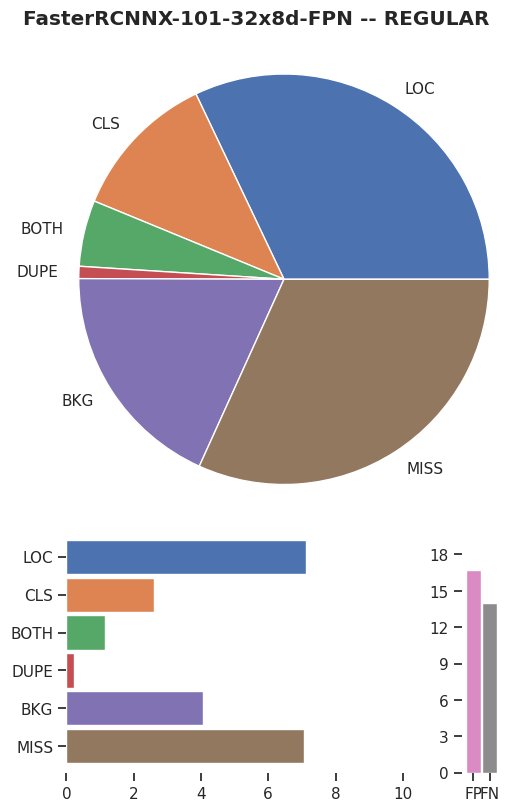

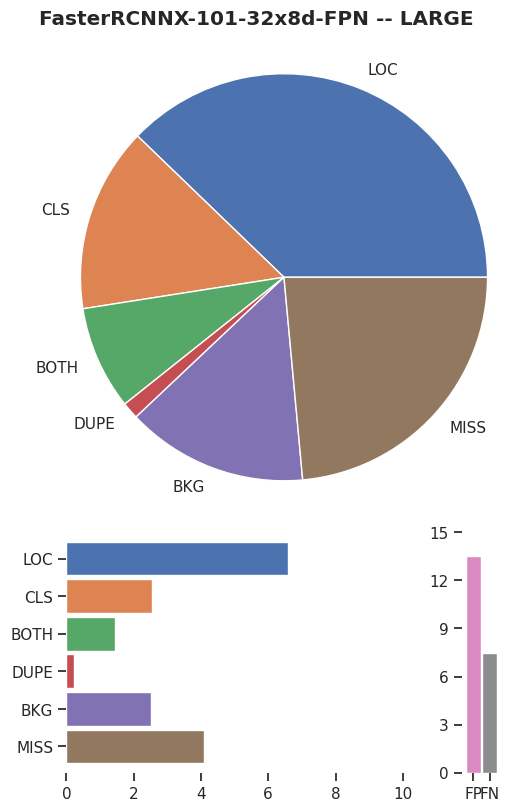

In [8]:
plot_tide('FasterRCNNX-101-32x8d-FPN -- REGULAR', tide)
plot_tide('FasterRCNNX-101-32x8d-FPN -- LARGE', tide_large)

## Advanced TIDE Features
As shown above with the per-class $\Delta$AP values, we sometimes try to give even more flexibility than the regular TIDE package.

One such feature, is that our TIDE implementation allows you to get all the detections and annotations, whilst showing their error types.
This might be useful to investigate the specific instances of eg. Background detections and try to understand why your model might be hallucinating or whether you have missing annotations.

In the code example below, we show how to create a dataframe which contains all of the detection and annotation errors, so that you can visualize them on your images.  
Actually showing the images with brambox is already explained in [a previous tutorial](./02-getting_started.ipynb#Visualisation), so we won't bother with that here.

In [9]:
# err_det is your detection dataframe with an extra "error" column
# err_anno is your annotation dataframe with an extra "error" column
tide = bb.eval.TIDE(det, anno)
err_det, err_anno = tide.errors

# Filter det/anno, so that only errors remain
err_det = err_det[err_det.error.notnull()]
err_anno = err_anno[err_anno.error.notnull()]

# Show dataframes for validation
print('Detection')
display(err_det.head())

print('Annotation')
display(err_anno.head())

Detection


image class_label  x_top_left  y_top_left       width  \
529   000000131556      person  228.496063   83.942802  144.263062   
578   000000038576       mouse  179.189316  223.992874   30.665680   
965   000000266892      person  216.206818  118.906616  120.587158   
1107  000000295713      person   94.000687   75.271957  151.260010   
1155  000000154004      person    0.046761   53.150696   86.861374   

          height  confidence         error  annotation  
529   213.243813    0.999703  localisation        8090  
578    30.684906    0.999688    background        <NA>  
965   261.206573    0.999538    background       16901  
1107  281.785660    0.999492          both       18864  
1155  274.954468    0.999475    background        9620

Annotation


image class_label  x_top_left  y_top_left  width  height  ignore  \
9   000000000139   microwave      512.22      205.75  14.74   15.97   False   
11  000000000139        book      604.77      305.89  14.34   45.71   False   
12  000000000139        book      613.24      308.24  12.88   46.44   False   
18  000000000139        vase      336.79      199.50   9.73   16.73   False   
23  000000000632        book      455.98      192.50   8.57   35.59   False   

         id  index   error  
9   1640282    9.0  missed  
11  1648594   11.0  missed  
12  1654394   12.0  missed  
18  2146548   18.0  missed  
23  1657298   23.0  missed

In [10]:
# Keep only the columns needed for plotting, so that we can merge det and anno
err_det = err_det[['image', 'class_label', 'x_top_left', 'y_top_left', 'width', 'height', 'error']]
err_anno = err_anno[['image', 'class_label', 'x_top_left', 'y_top_left', 'width', 'height', 'error']]

# Merge det and anno
boxes = bb.util.concat([err_det, err_anno])

boxes.head()

image class_label  x_top_left  y_top_left       width  \
529   000000131556      person  228.496063   83.942802  144.263062   
578   000000038576       mouse  179.189316  223.992874   30.665680   
965   000000266892      person  216.206818  118.906616  120.587158   
1107  000000295713      person   94.000687   75.271957  151.260010   
1155  000000154004      person    0.046761   53.150696   86.861374   

          height         error  
529   213.243813  localisation  
578    30.684906    background  
965   261.206573    background  
1107  281.785660          both  
1155  274.954468    background